### IMPORT & LOAD CSV

In [138]:
import csv
import math
import statistics

def load_csv(path):
    data = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.append(row)
    return data

data = load_csv("student_perfomance_predict.csv")
print("Total Data:", len(data))

Total Data: 1000


### PEMILIHAN FITUR & CLEANING

In [139]:
selected_features = [
    "AttendanceRate",
    "StudyHoursPerWeek",
    "PreviousGrade",
    "ExtracurricularActivities",
    "ParentalSupport",
    "Online Classes Taken"
]

def safe_float(x):
    if x is None or x.strip() == "":
        return None
    try:
        return float(x)
    except:
        return None

encode_parental = {"Low": 1, "Medium": 2, "High": 3}
encode_bool = {"False": 0, "True": 1}

X_raw = []
y_raw = []

for row in data:
    target = safe_float(row["FinalGrade"])   # nilai tujuan

    # HAPUS BARIS JIKA FINALGRADE KOSONG
    if target is None:
        continue

    feats = [
        safe_float(row["AttendanceRate"]),
        safe_float(row["StudyHoursPerWeek"]),
        safe_float(row["PreviousGrade"]),
        safe_float(row["ExtracurricularActivities"]),
        encode_parental.get(row["ParentalSupport"], None),
        encode_bool.get(row["Online Classes Taken"], None)
    ]

    # HAPUS BARIS JIKA ADA FITUR YANG KOSONG
    if None in feats:
        continue

    X_raw.append(feats)
    y_raw.append(target)

print("Total data setelah menghapus nilai kosong:", len(X_raw))


Total data setelah menghapus nilai kosong: 782


### IMPUTASI NILAI KOSONG PADA FITUR

In [140]:
col_mean = {}

for i in range(len(selected_features)):
    vals = [row[i] for row in X_raw if row[i] is not None]

    # Jika kolom fiturnya kosong total → jadikan 0
    if len(vals) == 0:
        col_mean[i] = 0.0
    else:
        col_mean[i] = statistics.mean(vals)

# Isi None dengan mean masing² kolom fitur
for row in X_raw:
    for i in range(len(row)):
        if row[i] is None:
            row[i] = col_mean[i]

# Target Y tidak diimputasi lagi
y = y_raw

### NORMALISASI MIN-MAX

In [141]:
min_val = {i: min(row[i] for row in X_raw) for i in range(len(selected_features))}
max_val = {i: max(row[i] for row in X_raw) for i in range(len(selected_features))}

def minmax(x, i):
    if max_val[i] == min_val[i]:
        return 0
    return (x - min_val[i]) / (max_val[i] - min_val[i])

### TRAIN TEST SPLIT

In [142]:
def train_test_split(X, y, test_size=0.2):
    n = int(len(X) * (1 - test_size))
    return X[:n], X[n:], y[:n], y[n:]

X_train, X_test, y_train, y_test = train_test_split(X, y)

### KNN REGRESSOR MANUAL

In [143]:
class KNNRegressor:
    def __init__(self, k=25):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def distance(self, a, b):
        return math.sqrt(sum((a[i] - b[i])**2 for i in range(len(a))))

    def predict_one(self, x):
        dists = []
        for i in range(len(self.X_train)):
            d = self.distance(x, self.X_train[i])
            dists.append((d, self.y_train[i]))

        dists.sort(key=lambda t: t[0])
        k_neighbors = dists[:self.k]
        return sum(v for d, v in k_neighbors) / len(k_neighbors)

    def predict(self, X):
        return [self.predict_one(x) for x in X]

### EVALUASI METRIKS

In [ ]:
y_pred = model.predict(X_test)

def MAE(y_true, y_pred):
    return sum(abs(y_true[i] - y_pred[i]) for i in range(len(y_true))) / len(y_true)

def MSE(y_true, y_pred):
    return sum((y_true[i] - y_pred[i])**2 for i in range(len(y_true))) / len(y_true)

def RMSE(y_true, y_pred):
    return math.sqrt(MSE(y_true, y_pred))

def R2(y_true, y_pred):
    mean_y = sum(y_true) / len(y_true)
    ss_res = sum((y_true[i] - y_pred[i])**2 for i in range(len(y_true)))
    ss_tot = sum((y_true[i] - mean_y)**2 for i in range(len(y_true)))
    return 1 - (ss_res / ss_tot)

print("=== EVALUASI MODEL ===")
print("MAE :", MAE(y_test, y_pred))
print("RMSE:", RMSE(y_test, y_pred))
print("R²  :", R2(y_test, y_pred))

=== EVALUASI MODEL ===
MAE : 11.13142006802721
RMSE: 12.083153860488974
R²  : -0.1789927082393259


### FUNGSI PREDICT MAHASISWA BARU

In [145]:
def predict_new(att, study_hours, prev_grade, extra, parent_support, online_class):
    # encoding kategori
    encode_parental = {"Low": 1, "Medium": 2, "High": 3}
    encode_bool = {"False": 0, "True": 1}

    row = [
        att,
        study_hours,
        prev_grade,
        extra,
        encode_parental.get(parent_support, 2),   # default Medium
        encode_bool.get(online_class, 0)
    ]

    # normalisasi pakai min_val & max_val yg sama dgn training
    norm = [
        minmax(row[i], i)
        for i in range(len(row))
    ]

    return model.predict_one(norm)

### TEST PREDICT

In [150]:
hasil_prediksi = [
    predict_new(95, 20, 90, 1, "High", "True"),    # Nilai Tinggi
    predict_new(80, 10, 75, 0, "Medium", "False"), # Nilai Sedang
    predict_new(60, 5, 60, 0, "Low", "False"),     # Nilai Rendah
    predict_new(20, 1, 10, 0, "Low", "False")      # Nilai Jelek
]

for i, nilai in enumerate(hasil_prediksi, 1):
    print(f"Prediksi {i}: {nilai}")


Prediksi 1: 83.42857142857143
Prediksi 2: 77.29002976190476
Prediksi 3: 70.4328869047619
Prediksi 4: 71.71860119047619


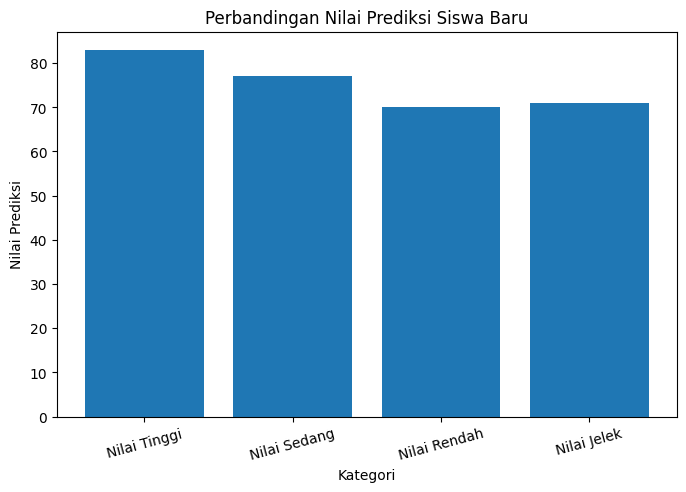